In [3]:
import scipy.io
import imageio
import os
import numpy as np

# Define the path to the data
currentDirectory = os.getcwd()

mat_dir = f"{currentDirectory}/dataset/original/human peritoneum/stacked mask"
output_mask_dir = f"{currentDirectory}/dataset/experiment/masks"
os.makedirs(output_mask_dir, exist_ok=True)

# Convert .mat to multiple .png masks (one per slice)
for filename in os.listdir(mat_dir):
    if filename.endswith(".mat"):
        path = os.path.join(mat_dir, filename)
        mat_data = scipy.io.loadmat(path)

        mask_stack = mat_data["stacked_mask"]  # Shape: (H, W, N) or (N, H, W)
        print(f"{filename} shape: {mask_stack.shape}")

        # Ensure (N, H, W)
        if mask_stack.shape[0] == 512 and mask_stack.shape[1] == 512:
            mask_stack = np.transpose(mask_stack, (2, 0, 1))  # Convert to (N, H, W)

        base_name = filename.replace(".mat", "")
        for i, slice_mask in enumerate(mask_stack):
            out_name = f"{base_name}_{i}.png"
            out_path = os.path.join(output_mask_dir, out_name)
            imageio.imwrite(out_path, slice_mask.astype(np.uint8))


human_peritoneum_1.mat shape: (512, 512, 35)
human_peritoneum_10.mat shape: (512, 512, 14)
human_peritoneum_11.mat shape: (512, 512, 49)
human_peritoneum_12.mat shape: (512, 512, 24)
human_peritoneum_2.mat shape: (512, 512, 25)
human_peritoneum_3.mat shape: (512, 512, 71)
human_peritoneum_4.mat shape: (512, 512, 75)
human_peritoneum_5.mat shape: (512, 512, 40)
human_peritoneum_6.mat shape: (512, 512, 40)
human_peritoneum_7.mat shape: (512, 512, 34)
human_peritoneum_8.mat shape: (512, 512, 31)
human_peritoneum_9.mat shape: (512, 512, 30)


In [5]:
import shutil
import os
from PIL import Image

currentDirectory = os.getcwd()

image_src_dir = f"{currentDirectory}/dataset/original/human peritoneum/weighted_maps"
mask_dir = f"{currentDirectory}/dataset/experiment/masks"
output_img_dir = f"{currentDirectory}/dataset/experiment/output_images"
os.makedirs(output_img_dir, exist_ok=True)

for mask_file in sorted(os.listdir(mask_dir)):
    if mask_file.endswith(".png"):
        base_name = "_".join(mask_file.split("_")[:3])  # e.g., human_peritoneum_3
        src_filename = base_name + ".png"
        src_filename = src_filename.replace(".png.png", ".png")  # 🛠️ Fix double .png

        src_path = os.path.join(image_src_dir, src_filename)
        dst_path = os.path.join(output_img_dir, mask_file)

        if os.path.exists(src_path):
            img = Image.open(src_path).convert("RGB")
            img.save(dst_path)
        else:
            print(f"⚠️ Missing source image for: {src_filename}")



import os

print("Number of images:", len(os.listdir(output_img_dir)))
print("Sample files:", os.listdir(output_img_dir)[:5])

Number of images: 468
Sample files: ['human_peritoneum_3_65.png', 'human_peritoneum_10_0.png', 'human_peritoneum_10_1.png', 'human_peritoneum_10_10.png', 'human_peritoneum_10_11.png']


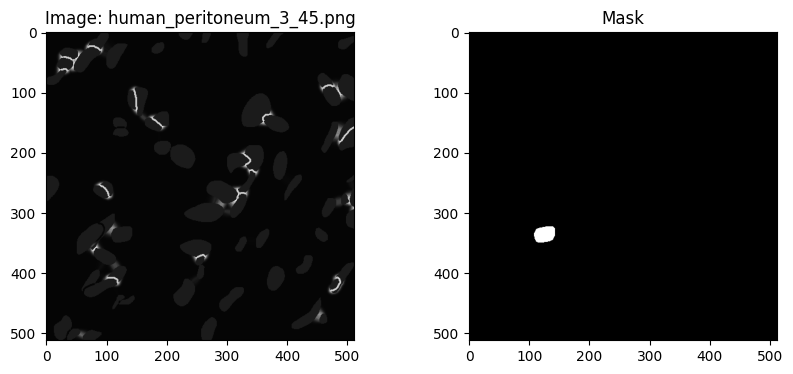

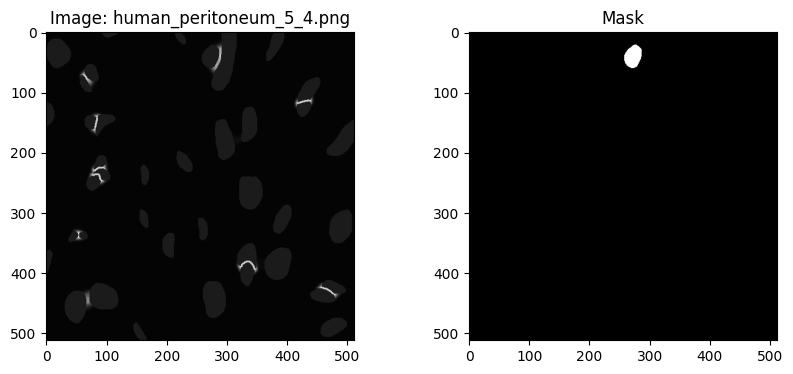

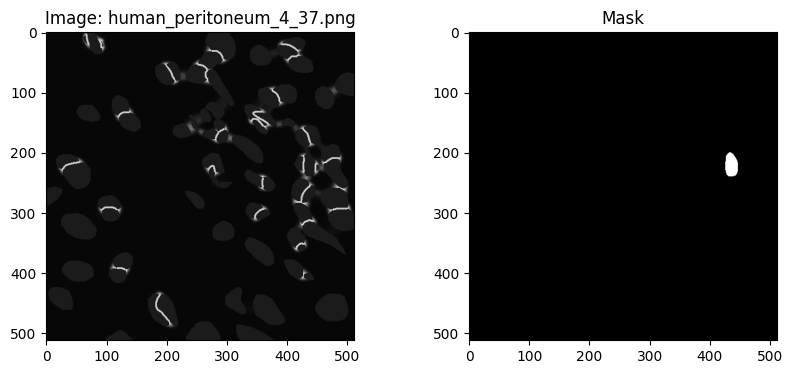

In [6]:
import random
import matplotlib.pyplot as plt
import cv2
import os



# Pick a random file from the image directory
sample_files = os.listdir(output_img_dir)
random_files = random.sample(sample_files, 3)

for file in random_files:
    img_path = os.path.join(output_img_dir, file)
    mask_path = os.path.join(mask_dir, file)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Image: {file}")
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.show()

In [7]:
import os, cv2, glob
import numpy as np
from torch.utils.data import Dataset
import torch

class NuInsSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.images = sorted(glob.glob(os.path.join(image_dir, "*.png")))
        self.masks = sorted(glob.glob(os.path.join(mask_dir, "*.png")))
        self.transform = transform
        assert len(self.images) == len(self.masks), "Mismatched image/mask count"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]  # Already a torch tensor

        # Debug the mask — check if it's all zeros
        # print(f"[DEBUG] Mask unique values (idx={idx}):", np.unique(mask))

        # Convert to float32 tensor
        mask = torch.tensor(mask, dtype=torch.float32)


        # ✅ Return as-is: transform already gives tensor
        return image, mask




In [8]:
# Print list of checkpoints in checkpoint folder:
!tree --du -h '{currentDirectory}/checkpoints'

[3.9G]  /mnt/Creative/SoftwareDevelopment/CAP_5516_Medical_Imaging_Computing/Assignments/Assignment_03/checkpoints
├── [ 39M]  mobile_sam.pt
├── [358M]  sam_vit_b_01ec64.pth
├── [2.4G]  sam_vit_h_4b8939.pth
└── [1.2G]  sam_vit_l_0b3195.pth

 3.9G used in 1 directory, 4 files


In [9]:
# ✅ Clear any previous CUDA errors
import torch
torch.cuda.empty_cache()
torch.cuda.synchronize()

device = "cuda" #cpu,cuda

from peft import get_peft_model, LoraConfig, TaskType
from mobile_sam import sam_model_registry
import torch.nn as nn

# Load base MobileSAM with LoRA
sam_checkpoint = f"{currentDirectory}/checkpoints/mobile_sam.pt"
model_type = "vit_t"
base_model = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)

# Configure LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["qkv", "proj"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.FEATURE_EXTRACTION,
)
lora_model = get_peft_model(base_model, lora_config)
lora_model.print_trainable_parameters()

# Wrap with decoder
class SAMWithDecoder(nn.Module):
    def __init__(self, sam_model):
        super().__init__()
        self.encoder = sam_model.image_encoder

        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 2, kernel_size=1)  # Binary segmentation
        )

    def forward(self, x):
        B, C, H, W = x.shape
        # print(f"[Input] x: {x.shape}")  # ✅ Sanity check input

        # Resize and normalize
        x = nn.functional.interpolate(x, size=(1024, 1024), mode='bilinear', align_corners=False)
        x = (x - 0.5) / 0.5
        # print(f"[Normalized] x: {x.shape}")  # ✅ Check preprocessing step

        # Pass through encoder
        features = self.encoder(x)
        # print(f"[Encoder output] features: {features.shape}")  # ✅ Confirm this is 4D (should be [B, 256, 32, 32])

        # Decoder output
        out = self.decoder(features)
        # print(f"[Decoder output before upsample] out: {out.shape}")  # e.g., [B, 2, 32, 32]

        # 🔼 Upsample to match ground truth mask resolution
        out = nn.functional.interpolate(out, size=(1024, 1024), mode='bilinear', align_corners=False)
        # print(f"[Decoder output after upsample] out: {out.shape}")  # Should now be [B, 2, 1024, 1024]

        return out


# ✅ Instantiate model for training
model = SAMWithDecoder(lora_model).cuda()


/home/malneyugnfl/anaconda3/envs/deeplearning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


trainable params: 89,088 || all params: 10,219,180 || trainable%: 0.8718


/home/malneyugnfl/anaconda3/envs/deeplearning/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/malneyugnfl/anaconda3/envs/deeplearning/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/malneyugnfl/anaconda3/envs/deeplearning/lib/python3.10/site-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/malneyu

In [10]:
from sklearn.metrics import f1_score, jaccard_score
import numpy as np

def dice_score(preds, targets):
    preds = preds.flatten()
    targets = targets.flatten()
    return f1_score(targets, preds, average='binary')

def iou_score(preds, targets):
    preds = preds.flatten()
    targets = targets.flatten()
    return jaccard_score(targets, preds, average='binary')

def compute_pq(preds, targets):
    # Placeholder PQ implementation (real PQ needs instance-level labels)
    # For simplicity, we'll just use Dice + IoU average
    dice = dice_score(preds, targets)
    iou = iou_score(preds, targets)
    return (dice + iou) / 2

In [ ]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from segmentation_models_pytorch.losses import DiceLoss

# Dataset Directory
currentDirectory = os.getcwd()
mask_dir = f"{currentDirectory}/dataset/experiment/masks"
img_dir = f"{currentDirectory}/dataset/experiment/output_images"

# Albumentations transform (resize + normalize)
transform = A.Compose([
    A.Resize(1024, 1024),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
], is_check_shapes=False)

# Load dataset
dataset = NuInsSegDataset(img_dir, mask_dir, transform=transform)
fold_size = len(dataset) // 5

all_dice, all_iou, all_pq = [], [], []

for fold in range(5):
    print(f"\n📂 Fold {fold + 1}")
    val_start = fold * fold_size
    val_end = (fold + 1) * fold_size if fold < 4 else len(dataset)
    indices = list(range(len(dataset)))
    val_indices = indices[val_start:val_end]
    train_indices = indices[:val_start] + indices[val_end:]

    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4)

    # Re-initialize model (to avoid stacking LoRA adapters)
    base_model = sam_model_registry[model_type](checkpoint=sam_checkpoint).cuda()
    lora_model = get_peft_model(base_model, lora_config)
    model = SAMWithDecoder(lora_model).cuda()

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    dice_loss = DiceLoss(mode='binary')

    # Training loop
    for epoch in range(10):
        model.train()
        total_loss = 0
        for step, (imgs, masks) in enumerate(train_loader):
            imgs, masks = imgs.cuda(), masks.cuda()

            if masks.sum() == 0:
                continue  # ⛔ Skip batches with all-zero masks

            preds = model(imgs)
            preds = F.interpolate(preds, size=masks.shape[1:], mode='bilinear', align_corners=False)

            foreground_logits = preds[:, 1, :, :]
            pos_weight = torch.tensor(20.0).cuda()  # 🔧 Adjust this if needed

            bce_loss = F.binary_cross_entropy_with_logits(foreground_logits, masks.float(), pos_weight=pos_weight)
            loss = dice_loss(torch.sigmoid(foreground_logits), masks.float()) + bce_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"✅ Epoch {epoch + 1} done. Avg Loss: {total_loss / len(train_loader):.4f}")


    # Validation loop
    model.eval()
    all_preds, all_masks = [], []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.cuda(), masks.cuda()
            preds = model(imgs)
            preds = F.interpolate(preds, size=masks.shape[1:], mode='bilinear', align_corners=False)

            foreground_probs = torch.sigmoid(preds[:, 1, :, :])
            # preds = (foreground_probs > 0.3).long()  # ⬅️ Lowered threshold
            preds = (foreground_probs > 0.1).long()  # Try 0.1 or even 0.05


            all_preds.append(preds.cpu().numpy())
            all_masks.append(masks.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_masks = np.concatenate(all_masks)

    # ⚠️ Check class imbalance
    print(f"🔍 Fold {fold + 1} mask foreground ratio: {all_masks.sum() / all_masks.size:.6f}")
    print(f"🔍 Fold {fold + 1} pred foreground ratio: {all_preds.sum() / all_preds.size:.6f}")

    d = dice_score(all_preds, all_masks)
    i = iou_score(all_preds, all_masks)
    pq = compute_pq(all_preds, all_masks)
    all_dice.append(d)
    all_iou.append(i)
    all_pq.append(pq)

    print(f"📊 Fold {fold + 1} Dice: {d:.4f} | IoU: {i:.4f} | PQ: {pq:.4f}")

    # Visualize predictions
    imgs = imgs.cpu().numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(imgs[0].transpose(1, 2, 0)); plt.title("Input")
    plt.subplot(1, 3, 2); plt.imshow(masks[0]); plt.title("Ground Truth")
    plt.subplot(1, 3, 3); plt.imshow(preds[0]); plt.title("Prediction")
    plt.tight_layout()
    plt.show()

# Final report
print("\n📈 Final Results (5-Fold Avg):")
print(f"Dice: {np.mean(all_dice):.4f} | IoU: {np.mean(all_iou):.4f} | PQ: {np.mean(all_pq):.4f}")


AttributeError: module 'os' has no attribute 'cwd'